In [1]:
using ModelingToolkit, OrdinaryDiffEq, Plots, DifferentialEquations


In [139]:
@variables t

#################################################
#                       FLOW                    #
#################################################

@connector function FlowPin(; name)
    sts = @variables T(t)=300.0 P(t)=20.0 ṁ(t)=1.0 [connect = Flow]
    ODESystem(Equation[], t, sts, []; name = name)
end

@component function FlowPort(; name)
    @named fp = FlowPin()
    @named fn = FlowPin()
    sts = @variables T(t) = 1.0 P(t)=1.0 ṁ(t)=1.0
    eqs = [T ~ fp.T - fn.T
            P ~ fp.P - fn.P
            0 ~ fp.ṁ - fn.ṁ
            ṁ ~ fp.ṁ]
    compose(ODESystem(eqs, t, sts, []; name = name), fp, fn)
end

@component function FlowGround(; name)
    @named fg = FlowPin()
    eqs = [fg.P ~ 0,
            fg.T ~ 0]
    compose(ODESystem(eqs, t, [], []; name = name), fg)
end

#################################################
#                       HEAT                    #
#################################################

@connector function HeatPin(; name)
    sts = @variables Q̇(t) = 1.0
    ODESystem(Equation[], t, sts, []; name = name)
end

@component function HeatPort(; name)
    @named qp = HeatPin()
    @named qn = HeatPin()
    sts = @variables Q̇(t) = 1.0
    eqs = [0 ~ qp.Q̇ - qn.Q̇
            Q̇ ~ qp.Q̇]
    compose(ODESystem(eqs, t, sts, []; name = name), qp, qn)
end

@component function HeatGround(; name)
    @named hg = HeatPin()
    eqs = [hg.Q̇ ~ 0]
    compose(ODESystem(eqs, t, [], []; name = name), hg)
end

#################################################
#                       WORK                    #
#################################################

@connector function WorkPin(; name)
    sts = @variables Ẇ(t) = 1.0
    ODESystem(Equation[], t, sts, []; name = name)
end

@component function WorkPort(; name)
    @named wp = WorkPin()
    @named wn = WorkPin()
    sts = @variables Ẇ(t) = 0.0
    eqs = [0 ~ wp.Ẇ - wn.Ẇ
            Ẇ ~ wp.Ẇ]
    compose(ODESystem(eqs, t, sts, []; name = name), wp, wn)
end

@component function WorkGround(; name)
    @named wg = WorkPin()
    eqs = [wg.Ẇ ~ 0]
    compose(ODESystem(eqs, t, [], []; name = name), wg)
end

@component function WorkSensor(;name)
    @named wmeas = WorkPin()
    @named wref = WorkPin()
    sts = @variables Ẇ(t)
    eqs = [
        Ẇ ~ wmeas.Ẇ - wref.Ẇ 
    ]
    extend(extend(ODESystem(eqs, t, [], []; name = name), wmeas),wref)
end

#################################################
#                     Reservoir                 #
#################################################

@component function FlowReservoir(; name, P_i = 10.0, T_i = 300.0)
    @named flowport = FlowPort()
    @unpack T,P = flowport
    ps = @parameters T_i = T_i P_i = P_i
    eqs = [
        T~T_i,
        P~P_i,
    ]
    extend(ODESystem(eqs, t, [], ps; name = name), flowport)
end

@component function MassFlowSource(; name, Ṁ = 1.0)
    @named flowport = FlowPort()
    @unpack ṁ,P,T = flowport
    ps = @parameters Ṁ = Ṁ
    eqs = [
         ṁ ~ Ṁ,
         P ~ 0,
         T ~ 0,
    ]
    extend(ODESystem(eqs, t, [], ps; name = name), flowport)
end

#################################################
#              Compressor Turbine               #
#################################################
@component function turb(;name, rp = 3.5, η = 0.9)
    @named flowport = FlowPort()
    # @named workport = PassiveWork()
    @unpack T,P,ṁ     = flowport
    # @unpack Ẇ = workport
    @variables Ẇ(t)
    ps = @parameters CR = rp η = η cp = 5192.0 k = 1.667

    eqs = [
        P ~ fp.P * (1/rp - 1),
        T ~ fp.T * (1 - η_isen * (1 - (1/rp) ^ ((k-1)/k))),
        Ẇ ~ ṁ * cp * T
    ]
    ODESystem(eqs, t, [], ps; name = name)
end

@component function compress(;name, rp = 3.5, η = 0.9)
    @named flowport = FlowPort()
    @unpack T,P,fp  = flowport
    ps = @parameters CR = rp η = η cp = 5192.0 k = 1.667
    sts = @variables Ẇ(t)
    kcoeff = (k-1)/k
    
    eqs = [
        P ~ fp.P * (rp - 1),
        T ~ fp.T * ((-1 + η + rp^((k-1)/k))/η - 1),
        Ẇ ~ fp.ṁ * cp * T
    ]
    extend(ODESystem(eqs, t,sts, ps; name = name), flowport)
end


compress (generic function with 1 method)

In [142]:
@named gnd = FlowGround()
@named reservoir = FlowReservoir(P_i = 1, T_i = 300)

mfunc(t) = cos(t)
@register_symbolic mfunc(t)

@named src = MassFlowSource(Ṁ = mfunc)
@named comp = compress()
@named cont = FlowPort()
@named gnd2 = FlowGround()


flow_eq = [ connect(src.fn, reservoir.fp),
            connect(reservoir.fn, comp.fp),
            connect(comp.fn, cont.fp),
            connect(cont.fn , src.fp),
            connect(cont.fn,gnd.fg)]

@named odeconnect = ODESystem(flow_eq,t, systems = [gnd,reservoir,src,comp,cont])
lsys0, ssys = linearize(odeconnect, src.ṁ, [comp.Ẇ])



┌ Warning: fg contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit C:\Users\harvey\.julia\packages\ModelingToolkit\FbXPg\src\systems\connectors.jl:40
┌ Warning: fp contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit C:\Users\harvey\.julia\packages\ModelingToolkit\FbXPg\src\systems\connectors.jl:40
┌ Warning: fn contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit C:\Users\harvey\.juli

┌ Warning: fp contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit C:\Users\harvey\.julia\packages\ModelingToolkit\FbXPg\src\systems\connectors.jl:40
┌ Warning: fn contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit C:\Users\harvey\.julia\packages\ModelingToolkit\FbXPg\src\systems\connectors.jl:40
┌ Warning: fp contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit C:\Users\harvey\.juli

MethodError: MethodError: no method matching float(::Type{Any})
Closest candidates are:
  float(::Type{Union{Missing, T}}) where T at missing.jl:112
  float(::Any) at float.jl:269
  float(!Matched::Union{StatsBase.PValue, StatsBase.TestStat}) at C:\Users\harvey\.julia\packages\StatsBase\XgjIN\src\statmodels.jl:86
  ...

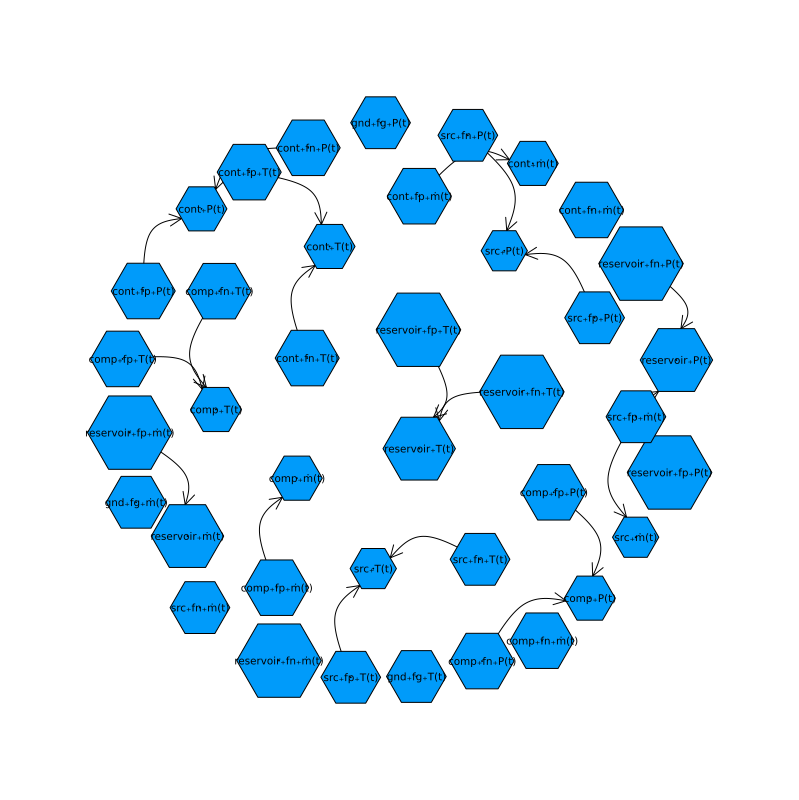

In [128]:
using Graphs, Plots, GraphRecipes
var2idx = Dict(s => i for (i, s) in enumerate(states(odesys)))
idx2var = Dict(i => s for (i, s) in enumerate(states(odesys)))


eqgraph = asgraph(equation_dependencies(odesys),var2idx)
equation_dep_digraph = asdigraph(eqgraph,odesys)
equation_dep_digraph.fadjlist
varvar = varvar_dependencies(asgraph(odesys), variable_dependencies(odesys))
varvar.badjlist
# varbigraph = variable_dependencies(odesys,variablestoids = var2idx)

# # eqeqdep = eqeq_dependencies(digr, variable_dependencies(odesys))
# vareqedep = equation_dependencies(odesys; variables = states(odesys))

# varvardep = variable_dependencies(odesys; variables = states(odesys), variablestoids = var2idx)
# digr = asgraph(vareqedep,var2idx)
# dg = asdigraph(digr, odesys; variables = states(odesys))
# varvardep = varvar_dependencies(digr, variable_dependencies(odesys))

# vvdepgr = asdigraph(varvardep,odesys)

# eqgr = eqeq_dependencies(digr,varvardep)

# # asd = asdigraph(digr,odesys)
nm = [idx2var[idx] for idx in 1:nv(varvar)]
graphplot(varvar, 
        size = (800,800),
        names = nm)
# collect(vertices(varvar))
# collect(edges(varvar))


In [ ]:


idx2var = Dict(i => s for (i, s) in enumerate(states(odesys)))

vardep = variable_dependencies(odesys,  variablestoids = Dict(s => i for (i, s) in enumerate(states(odesys))))
# graphplot(varvardep)
varvardep = varvar_dependencies(asgraph(odesys), vardep)
#          variables = states(odesys),
#          variablestoids = Dict(convert(Variable, v) => i for (i, v) in enumerate(variables))))

v = collect(vertices(varvardep))
nm = [idx2var[vidx] for vidx in v]

graphplot(varvardep, 
        size = (800,800),
        names = nm)



In [23]:
collect(vertices(varvardep))

39-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
  ⋮
 31
 32
 33
 34
 35
 36
 37
 38
 39

In [7]:
variable_dependencies(odesys)

BipartiteGraph with (39, 30) (𝑠,𝑑)-vertices
   #  src        dst
  1     [7]        ∅
  2     [6]        ∅
  3     ∅          ∅
  4     [8, 12]    ∅
  5     [9, 13]    ∅
  6     [11]       [2]
  7     ∅          [1]
  8     ∅          [4]
  9     ∅          [5]
  ⋮              
 31     [27]       ⋅
 32     [28]       ⋅
 33     [30]       ⋅
 34     ∅          ⋅
 35     ∅          ⋅
 36     ∅          ⋅
 37     ∅          ⋅
 38     ∅          ⋅
 39     ∅          ⋅